In [1]:
# install dependencies
!pip3 install gym --upgrade
!pip3 install pyglet
!pip3 install Box2D
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip3 install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import torch

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
# enviroment
import gym

env = gym.make('LunarLander-v2')
state_size =  env.observation_space.shape #TODO: find observation size
action_size =  env.action_space.n #TODO: find action size

In [3]:
# experience replay
import random
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ExperienceReplay():
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)
        
    def store_trans(self, s, a, sp, r, done):
        # TODO: store new transition in memory
        transition = Transition(s, a, sp, r, done)
        self.memory.append(transition)
        pass

    def sample(self, batch_size):
        # TODO: take RANDOM sample from memory
        experiences = random.sample(self.memory, batch_size)
        return experiences

    def __len__(self):
        return len(self.memory)

In [4]:
# DQN
import torch.nn as nn
import torch.nn.functional as F

class DeepQNetwork(nn.Module):
    def __init__(self, state_size, action_size) -> None:
        super(DeepQNetwork, self).__init__()
        # TODO: define the architecture
        # NOTE: input=observation/state, output=action
        self.layer1 = nn.Linear(state_size, 512)
        self.layer2 = nn.Linear(512, 512)
        self.layer3 = nn.Linear(512, 512)
        self.layer4 = nn.Linear(512, 512)
        self.layer5 = nn.Linear(512, 512)
        self.layer6 = nn.Linear(512, action_size)
        pass

    def forward(self, x):
        # TODO: forward propagation
        # NOTE: use ReLu for activation function in all layers 
        # NOTE: last layer has no activation function (predict action)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        return self.layer6(x)
        #####pass

## DQN

In [5]:
# DQN agent
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=1e-4):
        # network parameter
        self.state_size = state_size
        self.action_size = action_size

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # experience replay
        self.experience_replay = ExperienceReplay(capacity=buffer_size)

        # network
        self.value_net = DeepQNetwork(state_size, action_size).to(device)

        # optimizer
        # TODO: create adam for optimizing network's parameter (learning rate=alpha)
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=alpha)

    def take_action(self, state, eps=0.0):
        # TODO: take action using e-greedy policy
        # NOTE: takes action using the greedy policy with a probability of 1−𝜖 and a random action with a probability of 𝜖
        # NOTE: 


        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.value_net.eval()
        with torch.no_grad():
            action_values = self.value_net(state)
        self.value_net.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def update_params(self):
        if len(self.experience_replay) < self.batch_size:
            return
        # transition batch
        batch = Transition(*zip(*self.experience_replay.sample(self.batch_size)))

        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)

        # calculate loss w.r.t DQN algorithm

        # STEP1
        # TODO: compute the expected Q values [y]
        q_expected = self.value_net(state_batch).gather(1, action_batch)

        # STEP2
        # TODO: compute Q values [Q(s_t, a)]
        q_targets_next = self.value_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        q_targets = reward_batch + self.gamma * q_targets_next * (done_batch.logical_not())

        # STEP3
        # TODO: compute mse loss
        loss = F.mse_loss(q_expected, q_targets)

        # TODO: optimize the model
        # NOTE: DON'T forget to set the gradients to zeros
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        pass

    def save(self, fname):
        # TODO: save checkpoint
        print('\n...saving checkpoint...')
        torch.save(self.value_net.state_dict(), fname)
        print('...Saving Done...')
        pass

    def load(self, fname, device):
        # TODO: load checkpoint
        print('\n...loading checkpoint...')
        self.value_net.load_state_dict(torch.load(fname, map_location='cpu'))
        print('...Loading Done...')
        pass

In [6]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01

## DQN -> Batch = 32

In [ ]:
# training phase

# TODO: create agent
dqnAgent = DQNAgent(state_size=8, action_size=4, batch_size=32,
              gamma=0.99, buffer_size=25000, alpha=1e-4)

crs = np.zeros(n_episodes + 1) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    done = False
    observation = env.reset()
    cr = 0 # episode cummulative rewards
    while not done:
        # TODO: select and perform an action
        action = dqnAgent.take_action(observation, eps)

        # TODO: store transition in experience replay
        observation_, reward, done, info = env.step(action)
        dqnAgent.experience_replay.store_trans(observation, action, observation_, reward, done)
        
        # TODO: update agent
        dqnAgent.update_params()

        # TODO: update current state and episode cummulative rewards
        observation = observation_
        cr += reward
        
    # TODO: decay epsilon
    eps = max(eps_end, eps * eps_decay_rate)
    
    
    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode] = cr
    crs_recent.append(cr)

    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
      dqnAgent.save(f"episode{i_episode}_batch=32")
      print(f"checkpoint: episode{i_episode}")

    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

Episode 25	Average Reward: -247.34	Epsilon: 0.47
Episode 49	Average Reward: -146.88	Epsilon: 0.22
...saving checkpoint...
...Saving Done...
checkpoint: episode50
Episode 50	Average Reward: -149.27	Epsilon: 0.22
Episode 75	Average Reward: -141.44	Epsilon: 0.10
Episode 99	Average Reward: -43.07	Epsilon: 0.05
...saving checkpoint...
...Saving Done...
checkpoint: episode100
Episode 100	Average Reward: -34.50	Epsilon: 0.05
Episode 125	Average Reward: 82.72	Epsilon: 0.02
Episode 149	Average Reward: 160.97	Epsilon: 0.01
...saving checkpoint...
...Saving Done...
checkpoint: episode150
Episode 150	Average Reward: 159.22	Epsilon: 0.01
Episode 175	Average Reward: 173.97	Epsilon: 0.01
Episode 199	Average Reward: 143.65	Epsilon: 0.01
...saving checkpoint...
...Saving Done...
checkpoint: episode200
Episode 200	Average Reward: 144.64	Epsilon: 0.01
Episode 225	Average Reward: 183.21	Epsilon: 0.01
Episode 249	Average Reward: 214.34	Epsilon: 0.01
...saving checkpoint...
...Saving Done...
checkpoint: epi

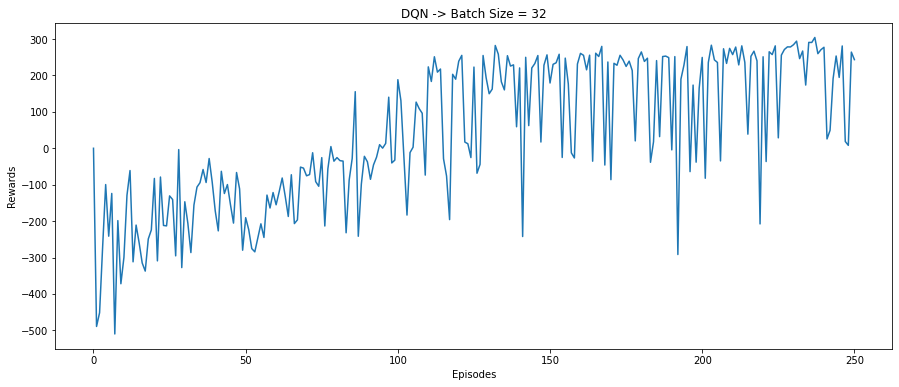

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(crs)
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.title('DQN -> Batch Size = 32')
plt.show()

In [ ]:
max(crs)

304.3768945835616

## DQN -> Batch Size = 64

In [38]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01

In [39]:
# training phase

# TODO: create agent
dqnAgent = DQNAgent(state_size=8, action_size=4, batch_size=64,
              gamma=0.99, buffer_size=25000, alpha=1e-4)

crs = np.zeros(n_episodes + 1) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    done = False
    observation = env.reset()
    cr = 0 # episode cummulative rewards
    while not done:
        # TODO: select and perform an action
        action = dqnAgent.take_action(observation, eps)

        # TODO: store transition in experience replay
        observation_, reward, done, info = env.step(action)
        dqnAgent.experience_replay.store_trans(observation, action, observation_, reward, done)
        
        # TODO: update agent
        dqnAgent.update_params()

        # TODO: update current state and episode cummulative rewards
        observation = observation_
        cr += reward
        
    # TODO: decay epsilon
    eps = max(eps_end, eps * eps_decay_rate)
    
    
    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode] = cr
    crs_recent.append(cr)

    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
      dqnAgent.save(f"episode{i_episode}_batch=64")
      print(f"checkpoint: episode{i_episode}")

    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

Episode 25	Average Reward: -171.69	Epsilon: 0.47
Episode 49	Average Reward: 7.14	Epsilon: 0.22
...saving checkpoint...
...Saving Done...
checkpoint: episode50
Episode 50	Average Reward: 18.43	Epsilon: 0.22
Episode 75	Average Reward: 156.95	Epsilon: 0.10
Episode 99	Average Reward: 182.77	Epsilon: 0.05
...saving checkpoint...
...Saving Done...
checkpoint: episode100
Episode 100	Average Reward: 169.04	Epsilon: 0.05
Episode 125	Average Reward: 182.65	Epsilon: 0.02
Episode 149	Average Reward: 218.39	Epsilon: 0.01
...saving checkpoint...
...Saving Done...
checkpoint: episode150
Episode 150	Average Reward: 208.83	Epsilon: 0.01
Episode 175	Average Reward: 204.69	Epsilon: 0.01
Episode 199	Average Reward: 178.07	Epsilon: 0.01
...saving checkpoint...
...Saving Done...
checkpoint: episode200
Episode 200	Average Reward: 178.80	Epsilon: 0.01
Episode 225	Average Reward: 210.15	Epsilon: 0.01
Episode 249	Average Reward: 221.27	Epsilon: 0.01
...saving checkpoint...
...Saving Done...
checkpoint: episode2

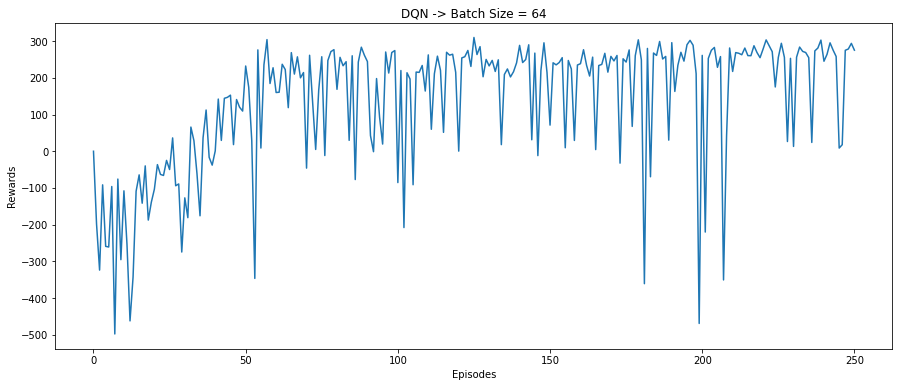

In [40]:
plt.figure(figsize=(15,6))
plt.plot(crs)
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.title('DQN -> Batch Size = 64')
plt.show()

In [41]:
max(crs)

310.20841470540904

## DQN -> Batch Size = 128

In [59]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01

In [60]:
# training phase

# TODO: create agent
dqnAgent = DQNAgent(state_size=8, action_size=4, batch_size=128,
              gamma=0.99, buffer_size=25000, alpha=1e-4)

crs = np.zeros(n_episodes + 1) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    done = False
    observation = env.reset()
    cr = 0 # episode cummulative rewards
    while not done:
        # TODO: select and perform an action
        action = dqnAgent.take_action(observation, eps)

        # TODO: store transition in experience replay
        observation_, reward, done, info = env.step(action)
        dqnAgent.experience_replay.store_trans(observation, action, observation_, reward, done)
        
        # TODO: update agent
        dqnAgent.update_params()

        # TODO: update current state and episode cummulative rewards
        observation = observation_
        cr += reward
        
    # TODO: decay epsilon
    eps = max(eps_end, eps * eps_decay_rate)
    
    
    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode] = cr
    crs_recent.append(cr)

    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
      dqnAgent.save(f"episode{i_episode}_batch=128")
      print(f"checkpoint: episode{i_episode}")

    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

Episode 25	Average Reward: -168.07	Epsilon: 0.47
Episode 49	Average Reward: 39.11	Epsilon: 0.22
...saving checkpoint...
...Saving Done...
checkpoint: episode50
Episode 50	Average Reward: 30.57	Epsilon: 0.22
Episode 75	Average Reward: 221.16	Epsilon: 0.10
Episode 99	Average Reward: 173.20	Epsilon: 0.05
...saving checkpoint...
...Saving Done...
checkpoint: episode100
Episode 100	Average Reward: 173.09	Epsilon: 0.05
Episode 125	Average Reward: 237.22	Epsilon: 0.02
Episode 149	Average Reward: 201.04	Epsilon: 0.01
...saving checkpoint...
...Saving Done...
checkpoint: episode150
Episode 150	Average Reward: 210.81	Epsilon: 0.01
Episode 175	Average Reward: 246.19	Epsilon: 0.01
Episode 199	Average Reward: 269.37	Epsilon: 0.01
...saving checkpoint...
...Saving Done...
checkpoint: episode200
Episode 200	Average Reward: 270.60	Epsilon: 0.01
Episode 225	Average Reward: 273.94	Epsilon: 0.01
Episode 249	Average Reward: 246.02	Epsilon: 0.01
...saving checkpoint...
...Saving Done...
checkpoint: episode

In [61]:
crs_dqn_128 = np.copy(crs)
max(crs)

317.98546908850636

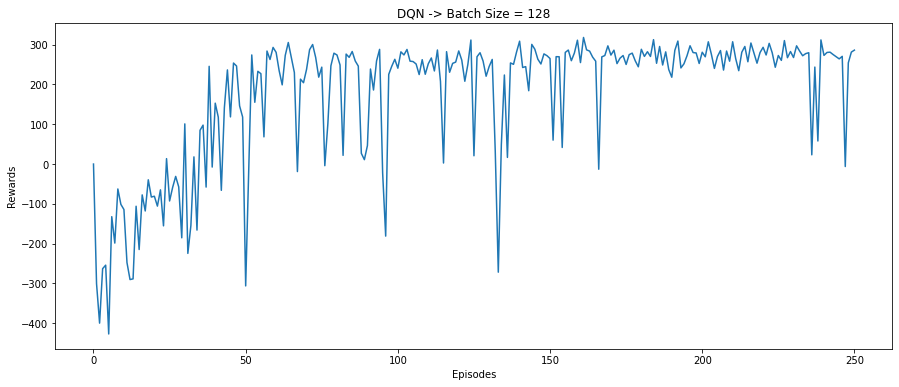

In [62]:
plt.figure(figsize=(15,6))
plt.plot(crs_dqn_128)
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.title('DQN -> Batch Size = 128')
plt.show()

## DDQN

In [51]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DDQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=1e-4):
        # network parameter
        self.state_size = state_size
        self.action_size = action_size

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # experience replay
        self.replay_buffer = ExperienceReplay(buffer_size)

        # networks
        self.value_net = DeepQNetwork(state_size, action_size).to(device)
        self.target_value_net = DeepQNetwork(state_size, action_size).to(device)
        self.update_target_network()

        # optimizer
        # TODO: create adam for optimizing network's parameter (learning rate=alpha)
        # NOTE: target network parameters DOSEN'T update with optimizer
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=alpha)



    def take_action(self, state, eps=0.0):
        # TODO: take action using e-greedy policy
        # NOTE: takes action using the greedy policy with a probability of 1−𝜖 and a random action with a probability of 𝜖
        # NOTE:

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.value_net.eval()
        with torch.no_grad():
            action_values = self.value_net(state)
        self.value_net.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

        pass

    def update_params(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        # transition batch

        batch = Transition(*zip(*self.replay_buffer.sample(self.batch_size)))
        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)


        # calculate loss w.r.t DQN algorithm

        # STEP1
        # TODO: compute the expected Q values [y]
        q_expected = self.value_net(state_batch).gather(-1, action_batch)
        next_actions = self.value_net(next_state_batch).argmax(-1, keepdim=True)

        # STEP2
        # TODO: compute Q values [Q(s_t, a)]
        q_targets_next = self.target_value_net(next_state_batch).gather(-1, next_actions)
        q_targets = reward_batch + self.gamma * q_targets_next * (done_batch.logical_not())

        # STEP3
        # TODO: compute mse loss
        loss = F.mse_loss(q_expected, q_targets)

        # TODO: optimize the model
        # NOTE: DON'T forget to set the gradients to zeros
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        # TODO: copy main network parameters to target network parameters
        for target_param, local_param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(local_param.data)                    

    def save(self, fname):
        # TODO: save checkpoint
        print('\n...saving checkpoint...')
        torch.save(self.value_net.state_dict(), fname)
        torch.save(self.target_value_net.state_dict(), fname)
        print('...Saving Done...')
        pass

    def load(self, fname, device):
        # TODO: load checkpoint
        print('\n...loading checkpoint...')
        self.value_net.load_state_dict(torch.load(fname, map_location='cpu'))
        self.target_value_net.load_state_dict(torch.load(fname, map_location='cpu'))
        print('...Loading Done...')
        pass

In [8]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01

In [65]:
# training phase

# TODO: create agent
ddqnAgent = DDQNAgent(state_size=8, action_size=4, batch_size=128,
              gamma=0.99, buffer_size=25000, alpha=1e-4)


crs = np.zeros(n_episodes + 1) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop

for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    done = False
    observation = env.reset()
    cr = 0 # episode cummulative rewards
    while not done:
        # TODO: select and perform an action
        action = ddqnAgent.take_action(observation, eps)

        # TODO: store transition in experience replay
        observation_, reward, done, info = env.step(action)
        ddqnAgent.replay_buffer.store_trans(observation, action, observation_, reward, done)
        
        # TODO: update agent
        ddqnAgent.update_params()
        
        # TODO: update current state and episode cummulative rewards
        observation = observation_
        cr += reward
    
    # TODO: decay epsilon
    eps = max(eps_end, eps * eps_decay_rate)

    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode] = cr
    crs_recent.append(cr)
    
    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
      ddqnAgent.save(f"episode{i_episode}_batch=128")
      print(f"checkpoint: episode{i_episode}")

    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

Episode 25	Average Reward: -137.65	Epsilon: 0.47
Episode 49	Average Reward: -143.58	Epsilon: 0.22
...saving checkpoint...
...Saving Done...
checkpoint: episode50
Episode 50	Average Reward: -150.16	Epsilon: 0.22
Episode 75	Average Reward: -199.68	Epsilon: 0.10
Episode 99	Average Reward: -185.70	Epsilon: 0.05
...saving checkpoint...
...Saving Done...
checkpoint: episode100
Episode 100	Average Reward: -187.57	Epsilon: 0.05
Episode 125	Average Reward: -130.60	Epsilon: 0.02
Episode 149	Average Reward: -106.27	Epsilon: 0.01
...saving checkpoint...
...Saving Done...
checkpoint: episode150
Episode 150	Average Reward: -111.89	Epsilon: 0.01
Episode 175	Average Reward: -96.58	Epsilon: 0.01
Episode 199	Average Reward: -102.88	Epsilon: 0.01
...saving checkpoint...
...Saving Done...
checkpoint: episode200
Episode 200	Average Reward: -96.64	Epsilon: 0.01
Episode 225	Average Reward: -91.29	Epsilon: 0.01
Episode 249	Average Reward: -60.06	Epsilon: 0.01
...saving checkpoint...
...Saving Done...
checkpoi

In [66]:
max(crs)
crs_ddqn_128 = np.copy(crs)

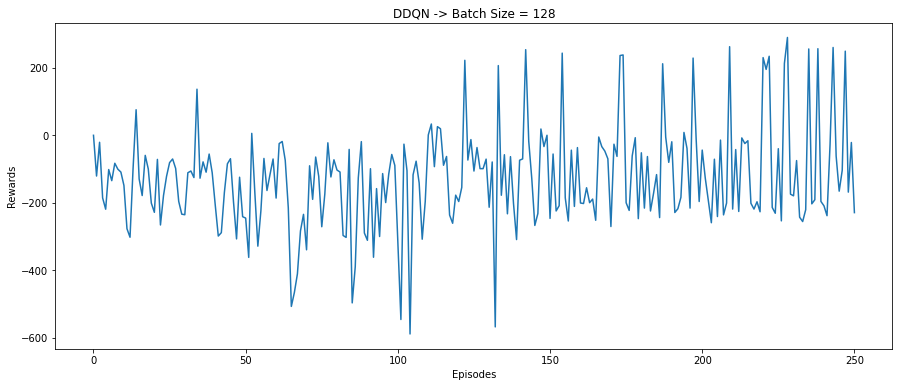

In [67]:
plt.figure(figsize=(15,6))
plt.plot(crs_ddqn_128)
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.title('DDQN -> Batch Size = 128')
plt.show()

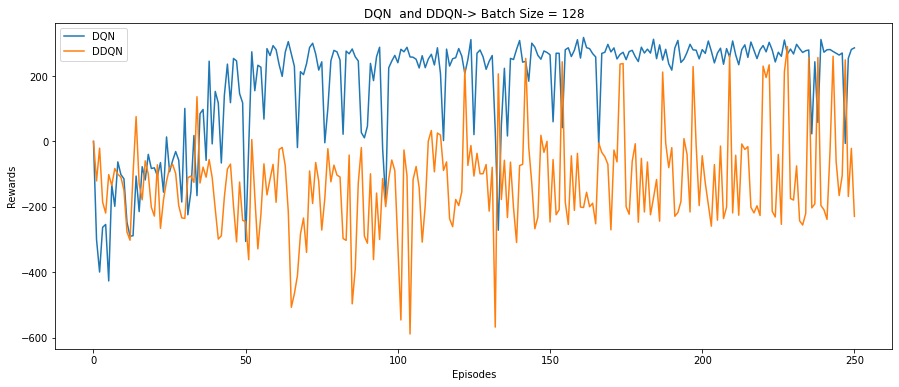

In [68]:
plt.figure(figsize=(15,6))
plt.plot(crs_dqn_128, label='DQN')
plt.plot(crs_ddqn_128, label='DDQN')
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.title('DQN  and DDQN-> Batch Size = 128')
plt.legend()
plt.show()

## MAking Videos

In [14]:
import os

In [21]:
conda install -c conda-forge ffmpeg

Solving environment: done

## Package Plan ##

  environment location: /Users/atefeh/opt/anaconda3

  added / updated specs:
    - ffmpeg


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.13.0               |   py37hf985489_1         998 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         998 KB

The following packages will be UPDATED:

  conda                               4.12.0-py37hf985489_0 --> 4.13.0-py37hf985489_1



conda-4.13.0         | 998 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [25]:
def make_video(agent, fname, env, eps):
    agent.load(fname, device)
    env = gym.wrappers.Monitor(env, os.path.join(os.getcwd()), force=True)
    state = env.reset()
    done = False
    while not done:
        action = agent.take_action(state, eps=eps)
        state, reward, done, _ = env.step(action)        
    env.close()

In [ ]:
def make_video_ddqn(agent, fname, env):
    agent.load(fname, device)
    env = gym.wrappers.Monitor(env, os.path.join(os.getcwd()), force=True)
    state = env.reset()
    done = False
    while not done:
        action = dqnAgent.take_action(state, eps=eps)
        state, reward, done, _ = env.step(action)        
    env.close()
    
    
dqnAgent = DQNAgent(state_size=8, action_size=4, batch_size=32,
                gamma=0.99, buffer_size=25000, alpha=1e-4)


#dqnAgent.value_net.load_state_dict(torch.load('episode50_batch=32', map_location='cpu'))
#ddqnAgent.target_value_net.load_state_dict(torch.load('episode50_batch=32', map_location='cpu'))
dqnAgent.load('episode50_batch=128', device)
env = gym.wrappers.Monitor(env, os.path.join(os.getcwd(), "videos"), force=True)


# Videos of PART B: DQN (for Best Batch Size = 128) -> episodes = 50, 100, 150, 200, 250

In [26]:
dqnAgent = DQNAgent(state_size=8, action_size=4, batch_size=128,
                gamma=0.99, buffer_size=25000, alpha=1e-4)
make_video(dqnAgent, "episode50_batch=128", env, eps)


...loading checkpoint...
...Loading Done...


In [27]:
make_video(dqnAgent, "episode100_batch=128", env, eps)


...loading checkpoint...
...Loading Done...


In [31]:
make_video(dqnAgent, "episode150_batch=128", env, eps)


...loading checkpoint...
...Loading Done...


In [34]:
make_video(dqnAgent, "episode200_batch=128", env, eps)


...loading checkpoint...
...Loading Done...


In [43]:
make_video(dqnAgent, "episode250_batch=128", env, eps)


...loading checkpoint...
...Loading Done...


# Videos of PART C:  DQN and DDQN -> episodes = 100, 250 (batch size = 128)
The videos for DQN is same as PART B due to the same batch size(128)

In [71]:
ddqnAgent = DDQNAgent(state_size=8, action_size=4, batch_size=128,
                gamma=0.99, buffer_size=25000, alpha=1e-4)

make_video(ddqnAgent, "episode100_batch=128", env, eps)


...loading checkpoint...
...Loading Done...


In [67]:
make_video(ddqnAgent, "episode250_batch=128", env, eps)


...loading checkpoint...
...Loading Done...
